In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime,timedelta
import tensorflow as tf
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# #HARDcoded
EPOCHS=20
TEST_SIZE=0.2
TIME_STEP=24
BATCH_SIZE = 32

In [3]:
#Load data
weather=pd.read_csv("/content/weatherHistory (1).csv")

In [4]:
weather.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [5]:
weather.shape

(96453, 12)

In [6]:
#Data Preprocessing
weather['datetime']=pd.to_datetime(weather['Formatted Date'],utc=True)#UTC to consider the time format is uts so the operations can be done
weather=weather[['datetime','Temperature (C)']]
weather=weather.rename({'Temperature (C)':'temp'},axis=1)
weather=weather.sort_values('datetime',axis=0,ascending=True)
weather=weather.reset_index(drop=True)
weather.shape

(96453, 2)

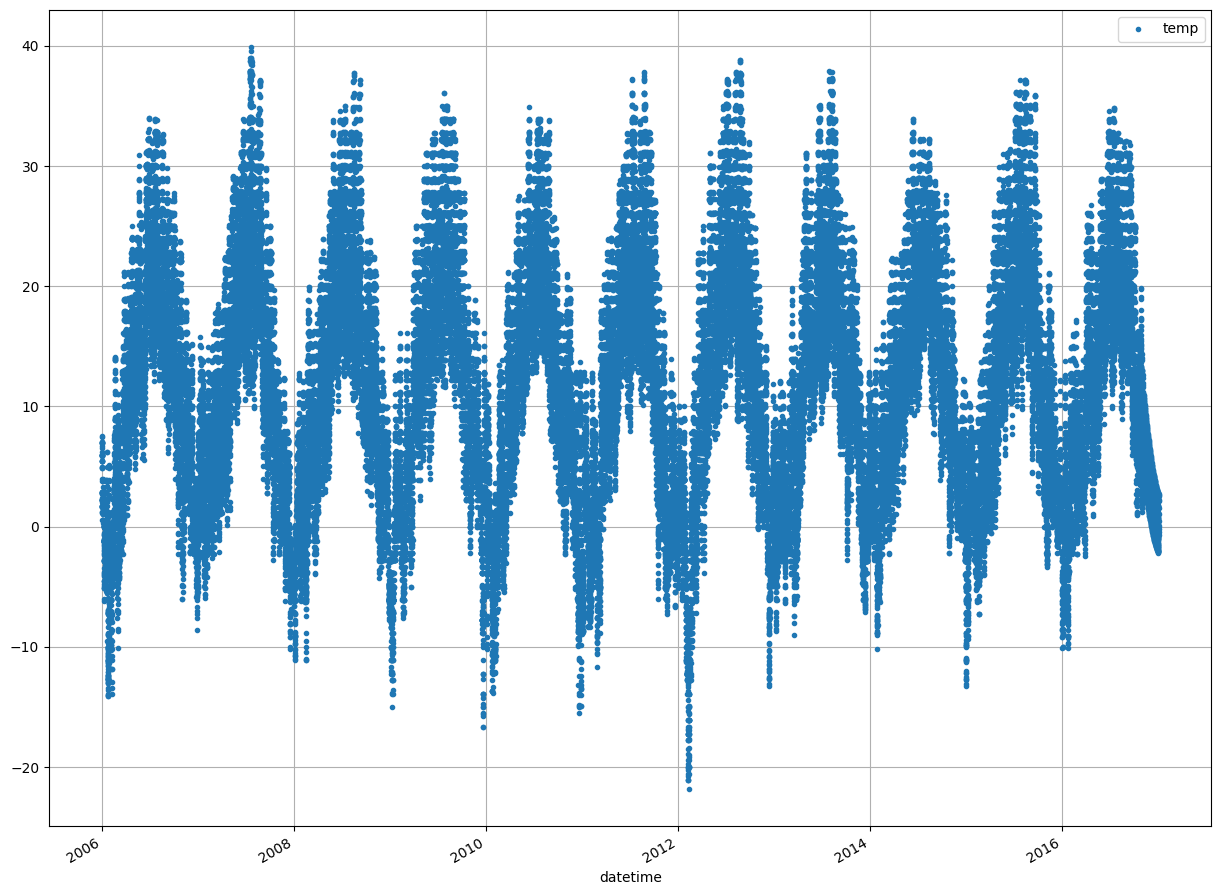

In [7]:
#Datetime representation
fig, ax = plt.subplots(figsize = (15,12))
weather.plot(x='datetime', y='temp', style=".", ax = ax);
ax.grid()

In [9]:
#Optional
#Model Creation
h_units=100
input_shape=(1,10000)

model=tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units=h_units,input_shape=input_shape,activation='tanh',))
model.add(tf.keras.layers.Dense(1,activation='linear'))

In [10]:
#Optional
#Weights of RNN
wax = model.get_weights()[0].shape # new input
waa = model.get_weights()[1].shape #Previous time step activation
baa = model.get_weights()[2].shape #Input bias
way = model.get_weights()[3].shape #Output of particular time step
bay = model.get_weights()[4].shape #Output bias
print(f"""If Shape of new input is={wax}\nActivation shape is={waa}\nInput bias sahpe={baa}\nOutput of particular time step={way}\nOutput bias ={bay} """)

If Shape of new input is=(10000, 100)
Activation shape is=(100, 100)
Input bias sahpe=(100,)
Output of particular time step=(100, 1)
Output bias =(1,) 


Now we want X and Y
So for this data X will contain  weather data of 23 hours and we will predict the 24th hour <br>
Therefore:<br>
X=df[0:23] for each time step<br>
Y=df[-1]<br>

In [11]:
#Creating Y
Y_filt=np.arange(TIME_STEP,weather.shape[0],TIME_STEP) #Filter :(24,number_of _rows,24)
y_df=weather.iloc[Y_filt] #Fitting filter on weather data
y_df

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556
...,...,...
96336,2016-12-27 02:00:00+00:00,-1.627778
96360,2016-12-28 02:00:00+00:00,-1.677778
96384,2016-12-29 02:00:00+00:00,-1.727778
96408,2016-12-30 02:00:00+00:00,-1.777778


In [12]:
#Creating X
X_temp=weather.iloc[range(len(y_df)*TIME_STEP)] # Whole data till last element of y_df
X_temp
X=np.reshape(X_temp['temp'].values,(y_df.shape[0], TIME_STEP,1)) #(X_temp array,in the shape of(4018,24))
X.shape
X=X[:,:23] #Excluding 24th
X.shape

(4018, 23, 1)

In [13]:
split = int(y_df.shape[0] * (1-TEST_SIZE))
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [14]:
h_units = 64
input_shape=(TIME_STEP-1, 1 ) # we are using one feature only.

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.SimpleRNN(units = h_units, input_shape = input_shape, activation = 'tanh'))
model.add(tf.keras.layers.Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error', optimizer='adam',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [15]:
history = model.fit(X_train, y_train,
                    epochs=EPOCHS,
                    validation_data=(X_test, y_test),
                    batch_size= BATCH_SIZE,
                    verbose=1)

Epoch 1/20
101/101 [==============================] - 3s 14ms/step - loss: 48.3192 - root_mean_squared_error: 6.9512 - val_loss: 12.0095 - val_root_mean_squared_error: 3.4655
Epoch 2/20
101/101 [==============================] - 1s 13ms/step - loss: 11.9886 - root_mean_squared_error: 3.4625 - val_loss: 4.2703 - val_root_mean_squared_error: 2.0665
Epoch 3/20
101/101 [==============================] - 1s 7ms/step - loss: 5.4334 - root_mean_squared_error: 2.3310 - val_loss: 2.1149 - val_root_mean_squared_error: 1.4543
Epoch 4/20
101/101 [==============================] - 1s 8ms/step - loss: 3.1478 - root_mean_squared_error: 1.7742 - val_loss: 1.4317 - val_root_mean_squared_error: 1.1965
Epoch 5/20
101/101 [==============================] - 1s 8ms/step - loss: 2.2141 - root_mean_squared_error: 1.4880 - val_loss: 1.0232 - val_root_mean_squared_error: 1.0115
Epoch 6/20
101/101 [==============================] - 1s 8ms/step - loss: 1.7538 - root_mean_squared_error: 1.3243 - val_loss: 0.8403 -

In [16]:
#Converting analysis to dataframe for plot
hist_df=pd.DataFrame(history.history)
# hist_df

Text(0, 0.5, 'Loss')

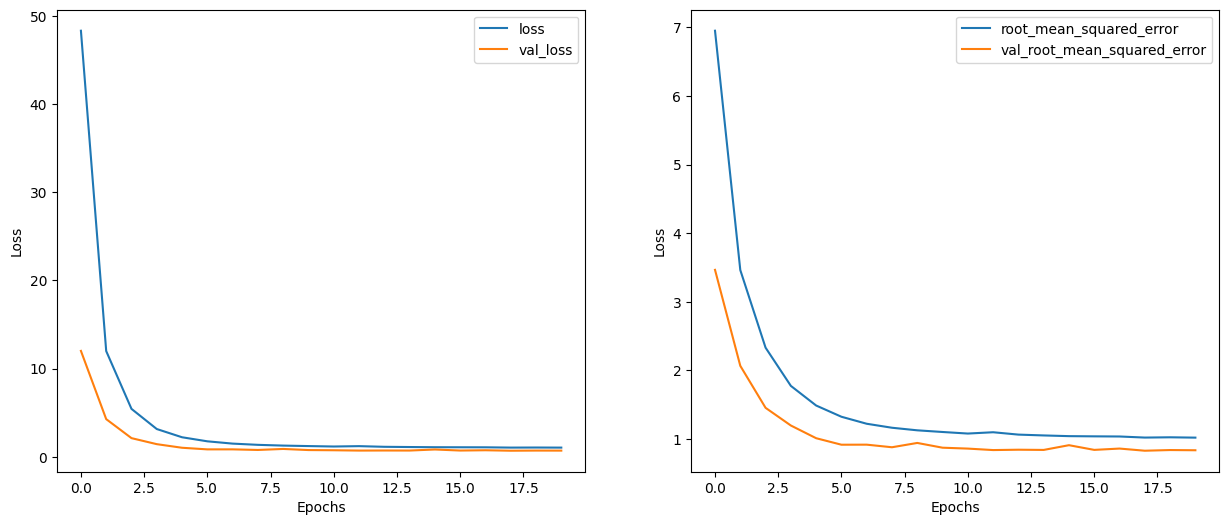

In [17]:
#Plotting
fig, axes = plt.subplots(1,2 , figsize = (15,6))

#Loss
ax = axes[0]
hist_df.plot(y = ['loss','val_loss'], ax = ax)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

#RMSE
ax1 = axes[1]
hist_df.plot(y = ['root_mean_squared_error', 'val_root_mean_squared_error'], ax = ax1)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

In [18]:
#Prediction
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_pred = np.append(y_train_pred, y_test_pred)

26/26 [==============================] - 0s 4ms/step


In [19]:
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df['datetime'] = res_df['datetime'].dt.date
res_df.head()

,datetime,temp,pred
24,2006-01-01,5.422222,4.977271
48,2006-01-02,1.694444,1.851763
72,2006-01-03,2.200000,2.063959
96,2006-01-04,1.666667,2.061933
120,2006-01-05,1.805556,2.413937


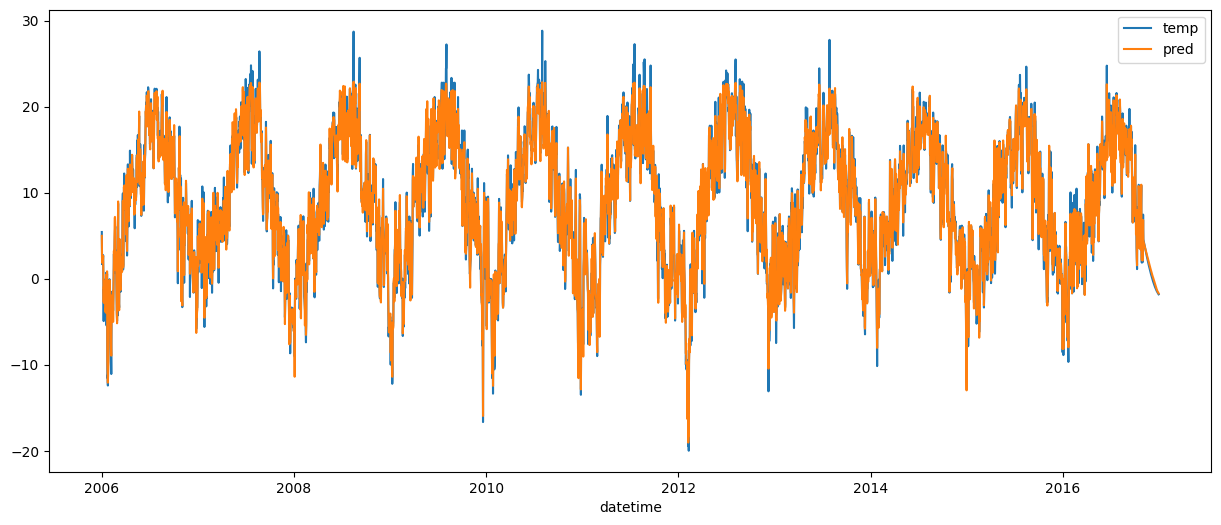

In [20]:
fig,ax=plt.subplots(figsize = (15,6))
res_df.plot(x='datetime', y=['temp','pred'],ax=ax);